In [1]:
from pydmd import BOPDMD
from pydmd.preprocessing import hankel_preprocessing
from pydmd.plotter import plot_summary
from signal_generator import SignalGenerator
from matplotlib import pyplot as plt
import numpy as np

In [2]:
signal_generator = SignalGenerator(x_min=-5, x_max=5, t_max=60)
signal_generator.add_sinusoid1(omega=0.5, k=1.5)
signal_generator.add_sinusoid2(omega=4)
signal_generator.add_noise(random_seed=42)

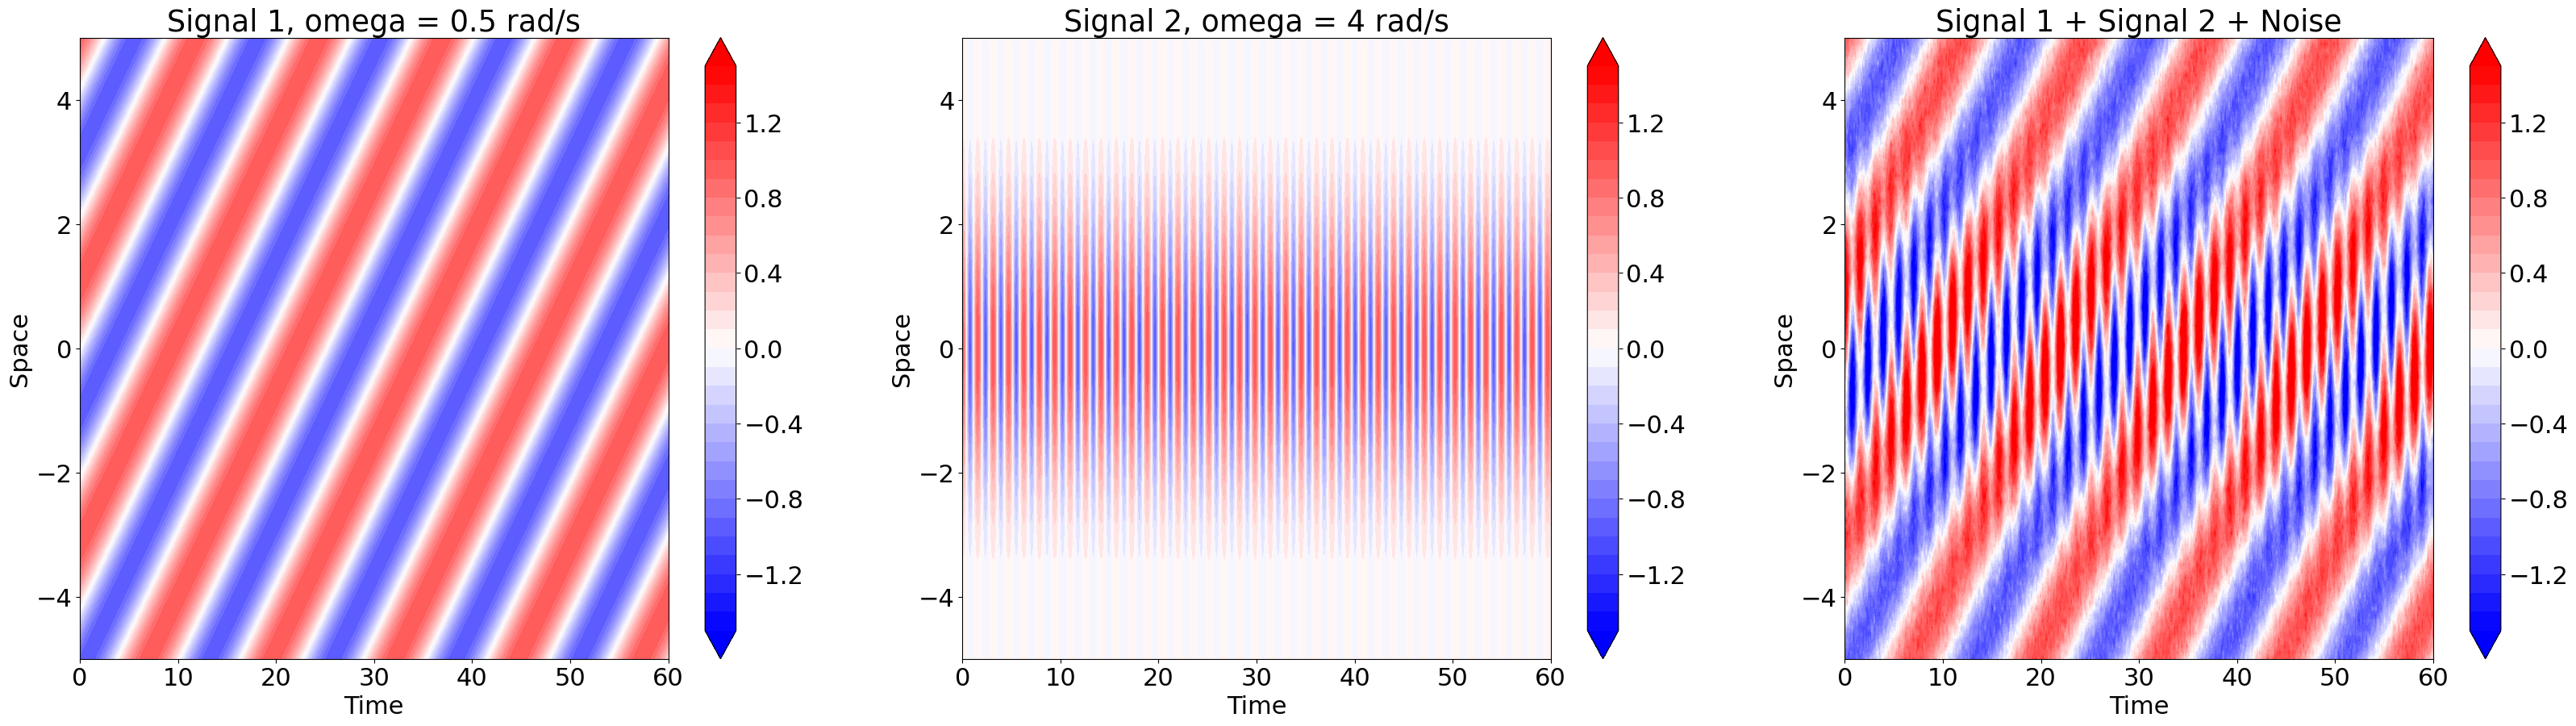

In [3]:
plt.rcParams.update({'font.size': 22})

fig = plt.figure(figsize=(40, 10))

vmin = -1.5; vmax = 1.5
levels = np.arange(vmin, vmax+0.1, 0.1)

ax = fig.add_subplot(1, 3, 1)
contour = ax.contourf(signal_generator.T, signal_generator.X, signal_generator.components[0]["signal"], levels=levels, cmap='bwr', extend='both')
plt.xlabel('Time')
plt.ylabel('Space')
plt.title(f'Signal 1, omega = {signal_generator.components[0]["omega"]} rad/s')
plt.colorbar(contour, ax=ax, orientation="vertical")

ax = fig.add_subplot(1, 3, 2)
contour = ax.contourf(signal_generator.T, signal_generator.X, signal_generator.components[1]["signal"], levels=levels, cmap='bwr', extend='both')
plt.xlabel('Time')
plt.ylabel('Space')
plt.title(f'Signal 2, omega = {signal_generator.components[1]["omega"]} rad/s')
plt.colorbar(contour, ax=ax, orientation="vertical")

ax = fig.add_subplot(1, 3, 3)
contour = ax.contourf(signal_generator.T, signal_generator.X, signal_generator.signal, levels=levels, cmap='bwr', extend='both')
plt.xlabel('Time')
plt.ylabel('Space')
plt.title('Signal 1 + Signal 2 + Noise')
plt.colorbar(contour, ax=ax, orientation="vertical")

plt.show()

In [4]:
svd_rank = 6
delay = 2

Algorithm 2

In [5]:
optdmd2 = BOPDMD(svd_rank=svd_rank, num_trials=0, use_proj=False)
delay_optdmd2 = hankel_preprocessing(optdmd2, d=delay)

Algorithm 3

In [6]:
optdmd3 = BOPDMD(svd_rank=svd_rank, num_trials=0, use_proj=True)
delay_optdmd3 = hankel_preprocessing(optdmd3, d=delay)

In [7]:
# fit DMD model to 80% of the data
train_frac = 0.8
f_train = signal_generator.signal[:int(train_frac * signal_generator.signal.shape[0]), :]
t_train = signal_generator.t[:int(train_frac * signal_generator.signal.shape[0])]
f_test = signal_generator.signal[int(train_frac * signal_generator.signal.shape[0]):, :]
t_test = signal_generator.t[int(train_frac * signal_generator.signal.shape[0]):]

In [8]:
t_delay = t_train[:-delay+1]
delay_optdmd2.fit(f_train.T, t=t_delay)
delay_optdmd3.fit(f_train.T, t=t_delay)

/Users/dsalvadorjasin/Documents/projects/MetOffice/DMD/toy_dataset/.venv/lib/python3.10/site-packages/pydmd/bopdmd.py:751: UserWarning: Initial trial of Optimized DMD failed to converge. Consider re-adjusting your variable projection parameters with the varpro_opts_dict and consider setting verbose=True.
  warnings.warn(msg)


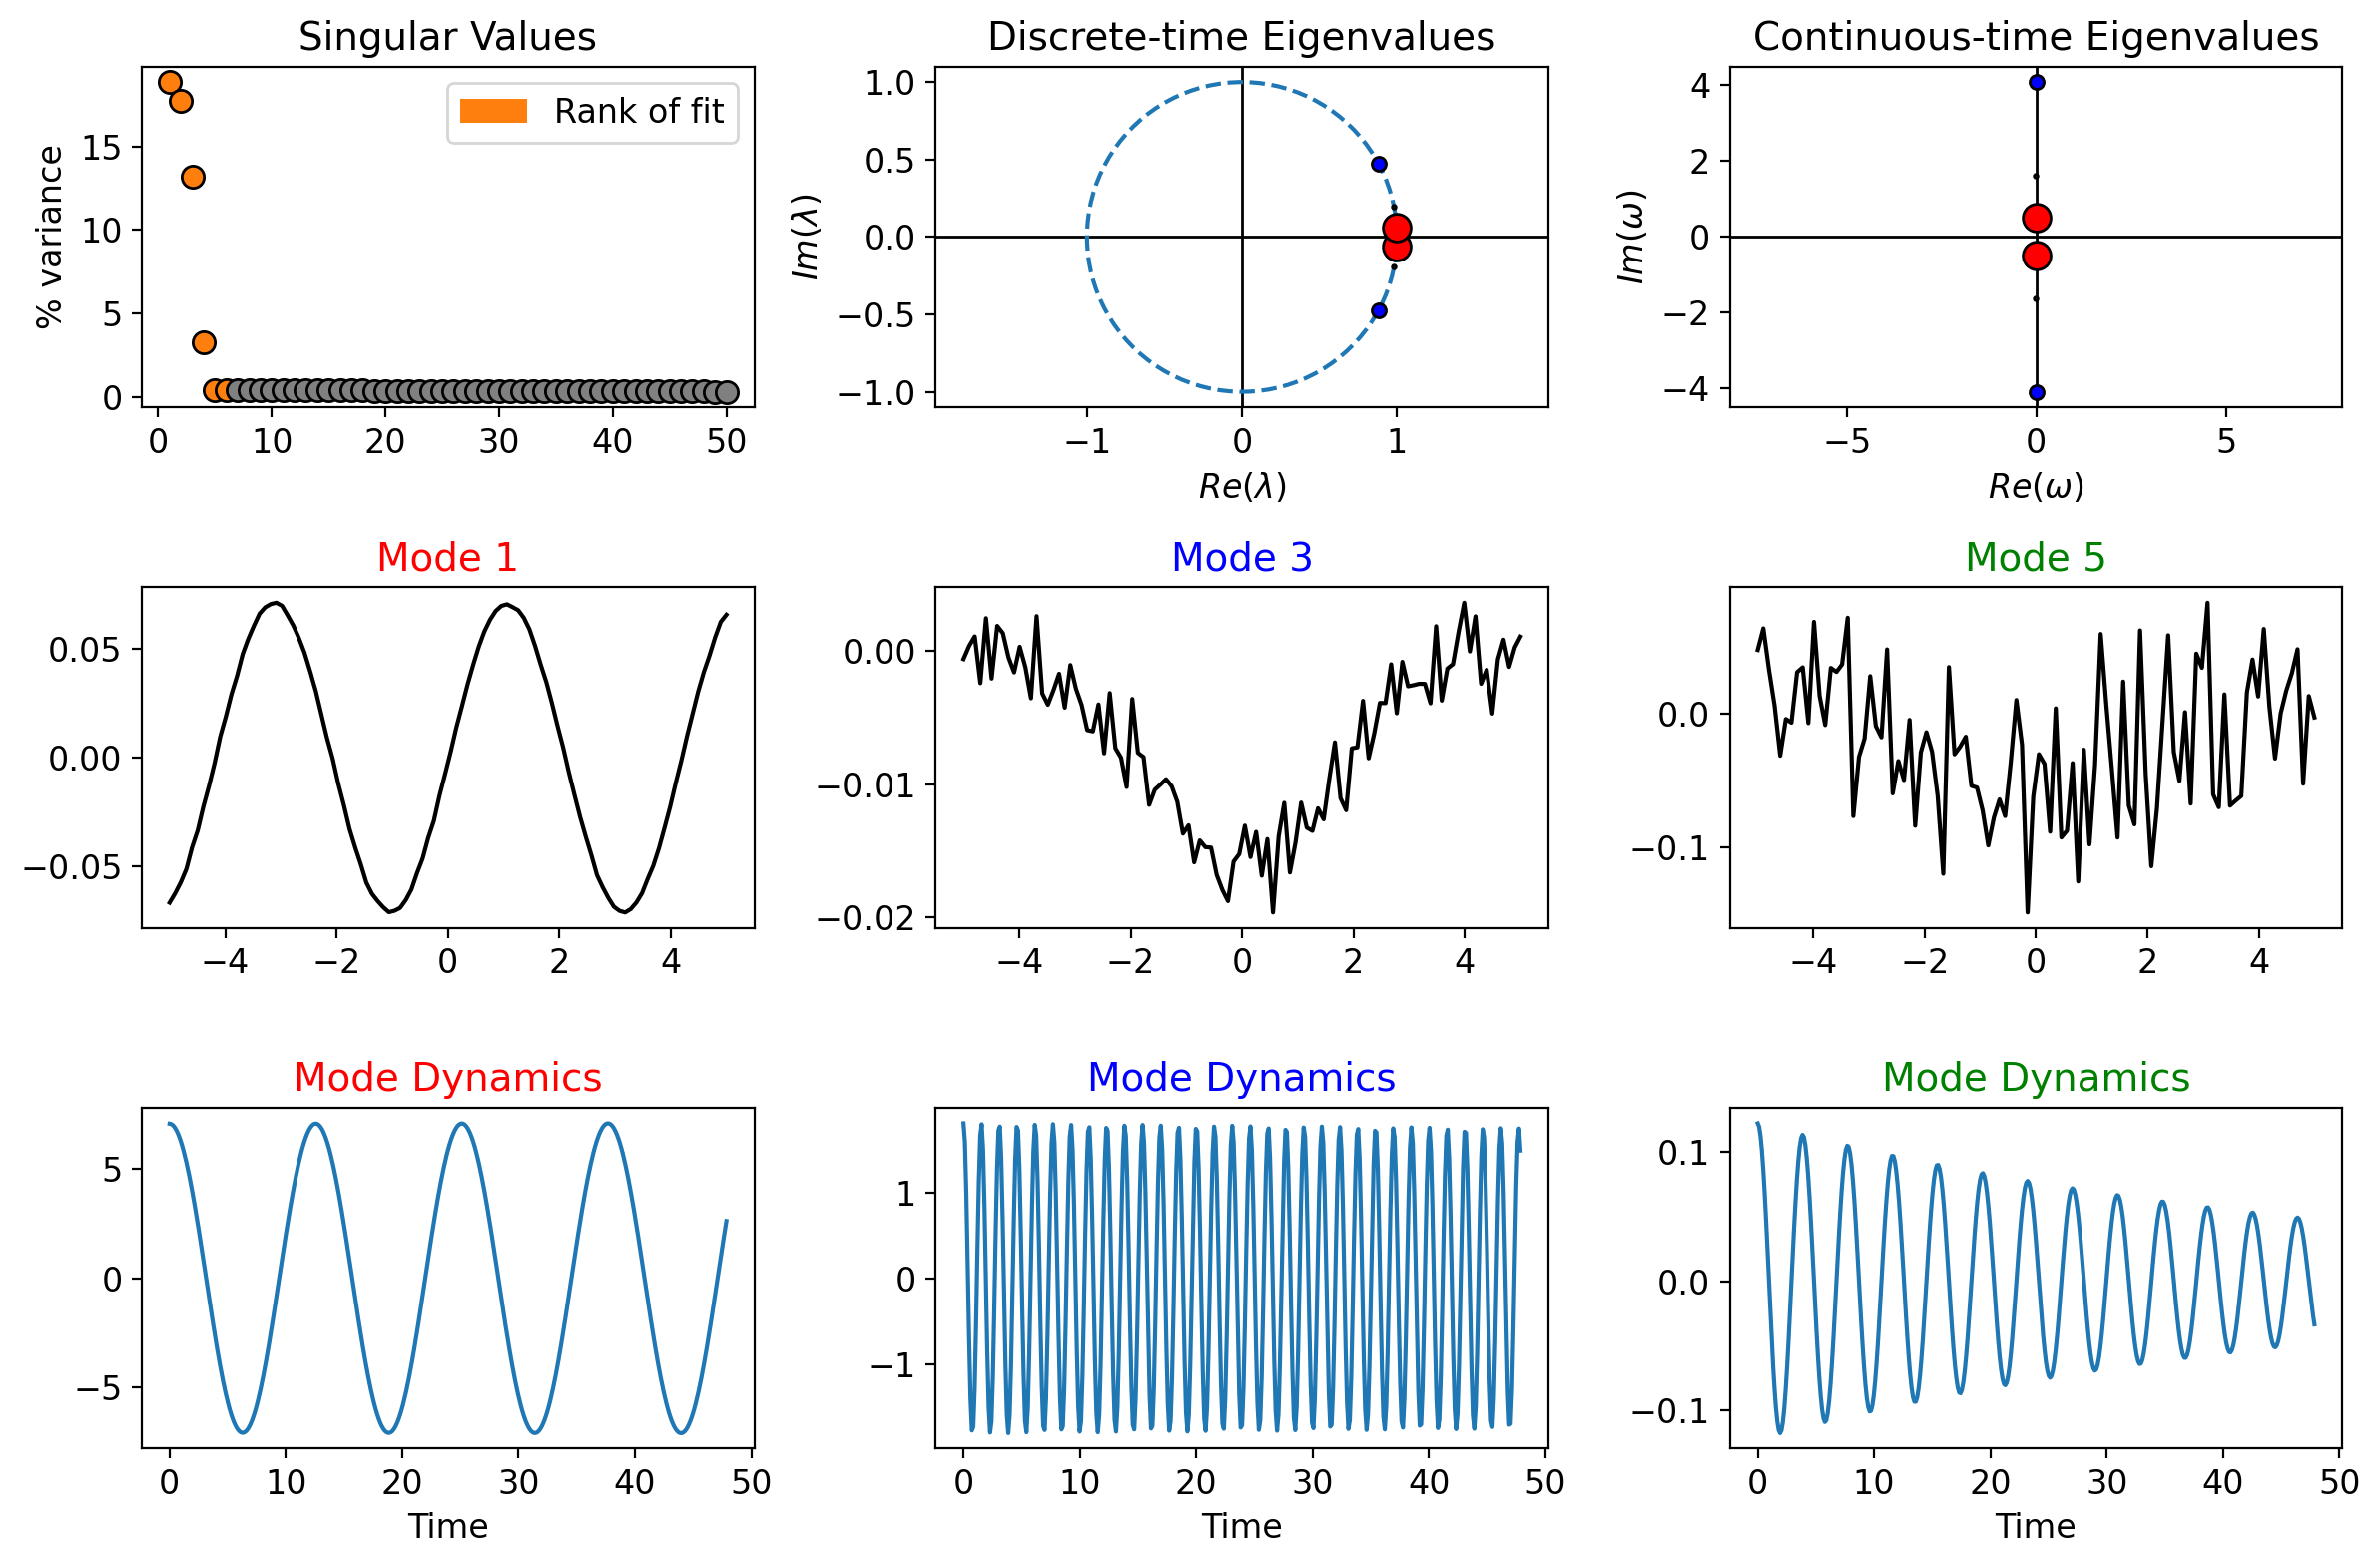

In [9]:
plt.rcParams.update({'font.size': 12})
plot_summary(delay_optdmd2, x=signal_generator.x, d=delay, index_modes=[0, 2, 4])

In [10]:
sorted_index = np.argsort(delay_optdmd2.amplitudes)[::-1]
print(f"Amplitudes: {delay_optdmd2.amplitudes[sorted_index]}")
print(f"Eigenvalues: {delay_optdmd2.eigs[sorted_index]}")

Amplitudes: [7.0625085  7.0625085  1.80988129 1.80988129 0.12202611 0.12202611]
Eigenvalues: [ 6.72822695e-05-0.50025783j  6.72822695e-05+0.50025783j
 -6.67338329e-04+4.08165061j -6.67338329e-04-4.08165061j
 -1.95370469e-02-1.62451662j -1.95370469e-02+1.62451662j]


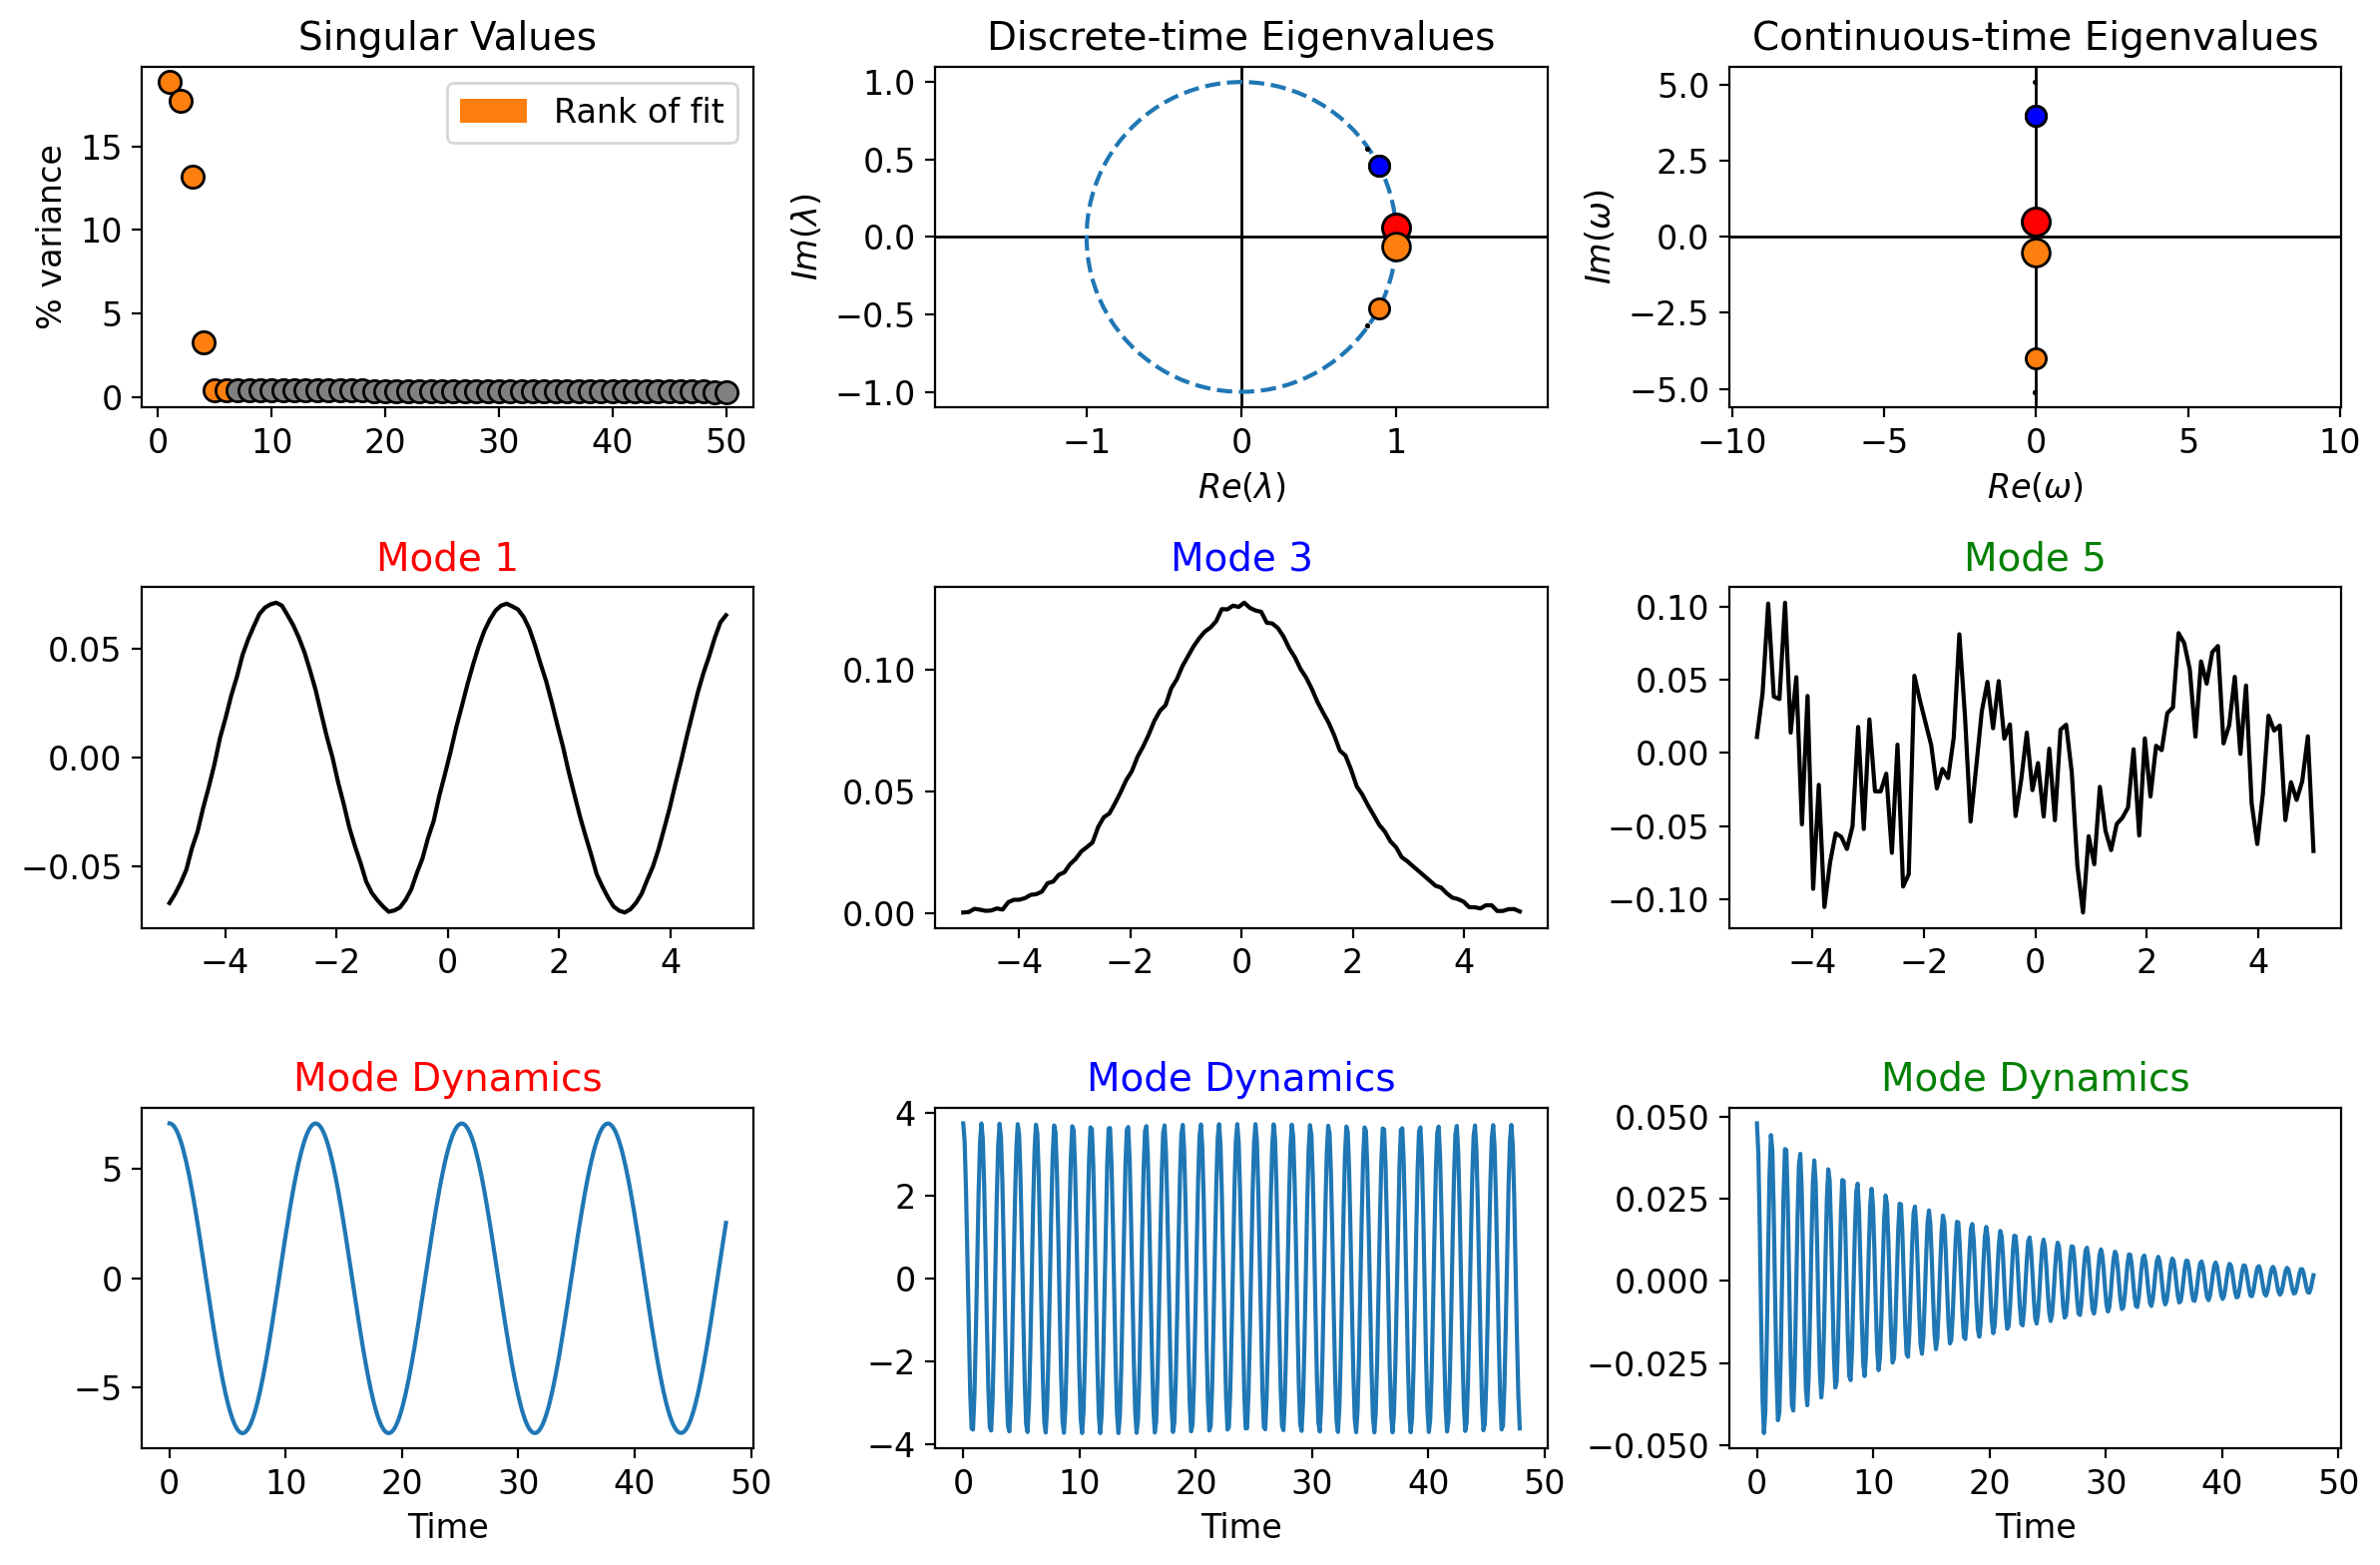

In [11]:
plt.rcParams.update({'font.size': 12})
plot_summary(delay_optdmd3, x=signal_generator.x, d=delay, index_modes=[0, 2, 4])

In [12]:
sorted_index = np.argsort(delay_optdmd3.amplitudes)[::-1]
print(f"Amplitudes: {delay_optdmd3.amplitudes[sorted_index]}")
print(f"Eigenvalues: {delay_optdmd3.eigs[sorted_index]}")

Amplitudes: [7.07942458 7.07942458 3.73872152 3.73872152 0.04799032 0.04799032]
Eigenvalues: [-3.17658898e-05+0.50001276j -3.17658898e-05-0.50001276j
 -1.98018803e-04+3.99989095j -1.98018803e-04-3.99989095j
 -5.42758898e-02-5.09836038j -5.42758898e-02+5.09836038j]


In [13]:
forecast2 = delay_optdmd2.forecast(t_test)
forecast2 = forecast2[:signal_generator.x.shape[0], :]  # note than need to do this because of the time delay embedding
forecast2 = forecast2.T
forecast2 = forecast2.real

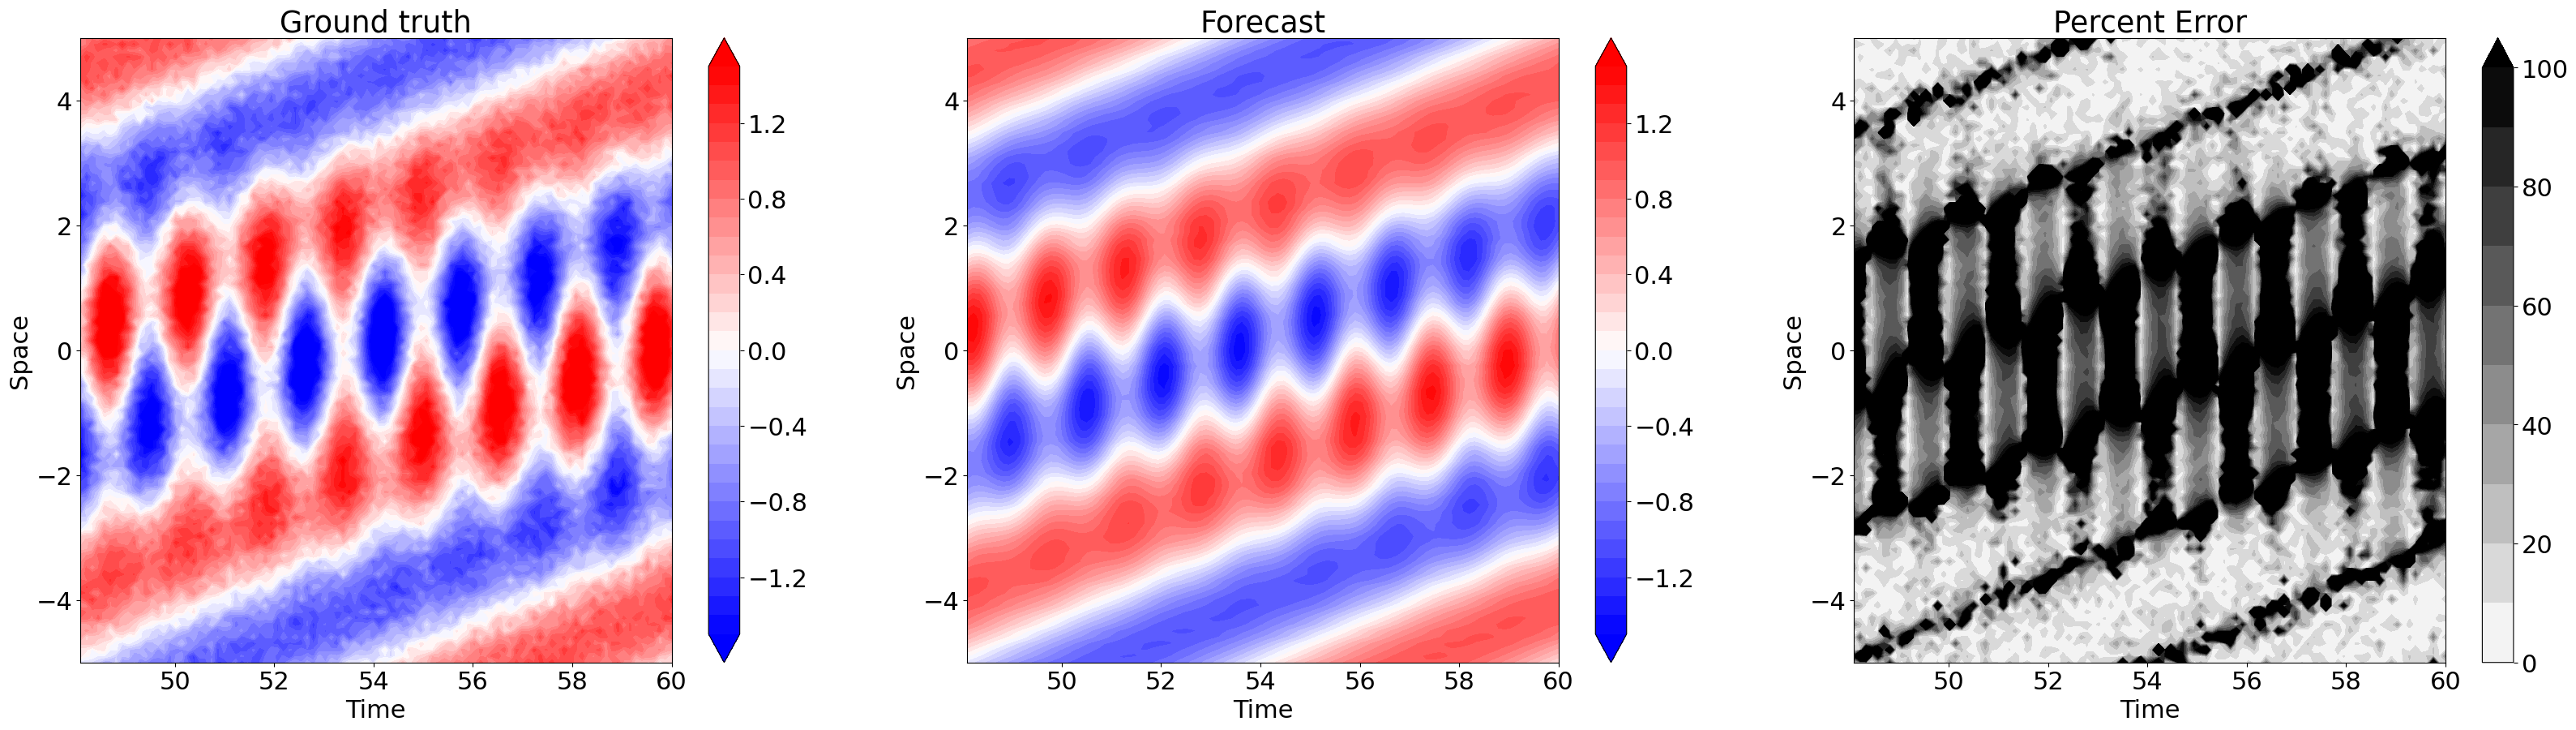

In [14]:
# compare the forecast to the ground truth

plt.rcParams.update({'font.size': 22})

X, T = np.meshgrid(signal_generator.x, t_test) 

fig = plt.figure(figsize=(40, 10))

vmin = -1.5; vmax = 1.5
levels = np.arange(vmin, vmax+0.1, 0.1)

ax = fig.add_subplot(1, 3, 1)
contour = ax.contourf(T, X, f_test, levels=levels, cmap='bwr', extend="both")
plt.xlabel('Time')
plt.ylabel('Space')
plt.title("Ground truth")
plt.colorbar(contour, ax=ax, orientation="vertical")

ax = fig.add_subplot(1, 3, 2)
contour = ax.contourf(T, X, forecast2, levels=levels, cmap='bwr', extend="both")
plt.xlabel('Time')
plt.ylabel('Space')
plt.title('Forecast')
plt.colorbar(contour, ax=ax, orientation="vertical")

# plot the percent error
percent_error = np.abs(f_test - forecast2) / np.abs(f_test) * 100
ax = fig.add_subplot(1, 3, 3)
contour = ax.contourf(T, X, percent_error, levels=np.arange(0, 101, 10), cmap='gray_r', extend="max")
plt.xlabel('Time')
plt.ylabel('Space')
plt.title('Percent Error')
plt.colorbar(contour, ax=ax, orientation="vertical")

plt.show()

In [15]:
forecast3 = delay_optdmd3.forecast(t_test)
forecast3 = forecast3[:signal_generator.x.shape[0], :]  # note than need to do this because of the time delay embedding
forecast3 = forecast3.T
forecast3 = forecast3.real

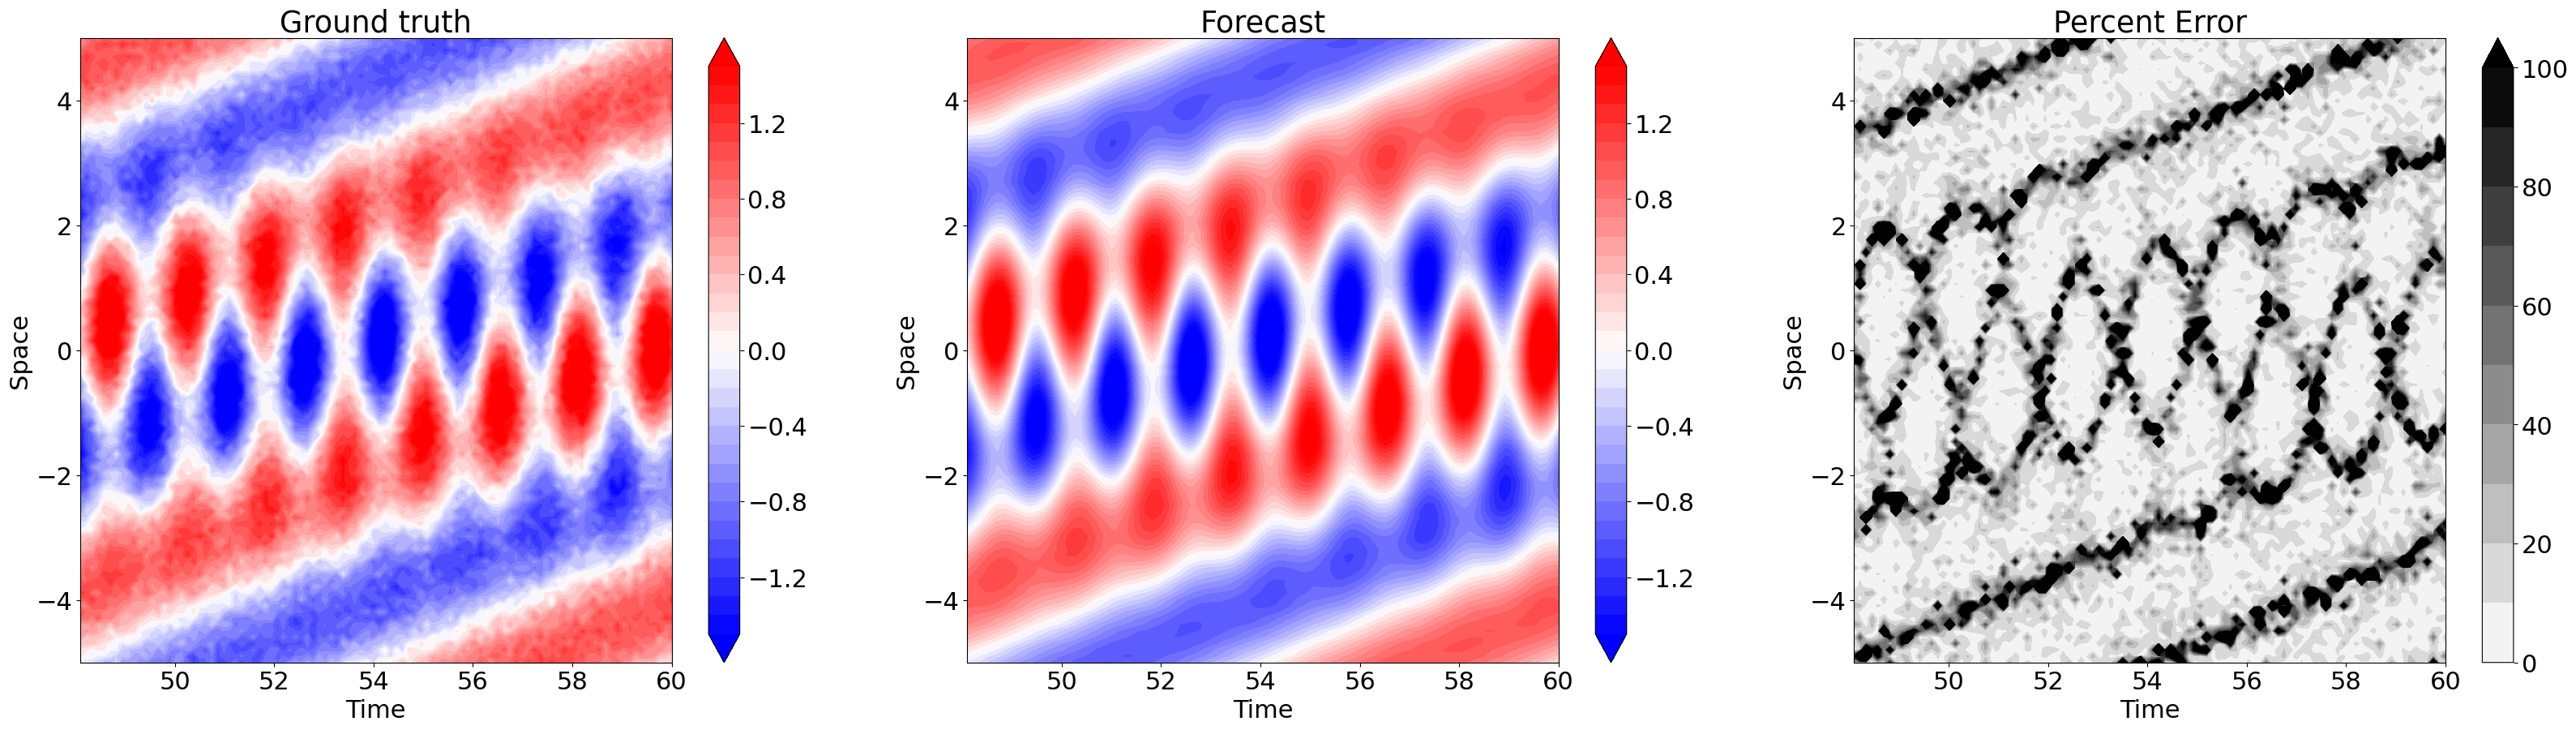

In [16]:
# compare the forecast to the ground truth

plt.rcParams.update({'font.size': 22})

X, T = np.meshgrid(signal_generator.x, t_test) 

fig = plt.figure(figsize=(40, 10))

vmin = -1.5; vmax = 1.5
levels = np.arange(vmin, vmax+0.1, 0.1)

ax = fig.add_subplot(1, 3, 1)
contour = ax.contourf(T, X, f_test, levels=levels, cmap='bwr', extend="both")
plt.xlabel('Time')
plt.ylabel('Space')
plt.title("Ground truth")
plt.colorbar(contour, ax=ax, orientation="vertical")

ax = fig.add_subplot(1, 3, 2)
contour = ax.contourf(T, X, forecast3, levels=levels, cmap='bwr', extend="both")
plt.xlabel('Time')
plt.ylabel('Space')
plt.title('Forecast')
plt.colorbar(contour, ax=ax, orientation="vertical")

# plot the percent error
percent_error = np.abs(f_test - forecast3) / np.abs(f_test) * 100
ax = fig.add_subplot(1, 3, 3)
contour = ax.contourf(T, X, percent_error, levels=np.arange(0, 101, 10), cmap='gray_r', extend="max")
plt.xlabel('Time')
plt.ylabel('Space')
plt.title('Percent Error')
plt.colorbar(contour, ax=ax, orientation="vertical")

plt.show()